In [1]:
import os
import glob
import librosa
import pandas as pd
import numpy as np
import soundfile as sf
import librosa.display
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
SAMPLERATE = 48000
PATH_FLAC_TRAIN = '../input/rfcx-species-audio-detection/train'

In [2]:
def cut_train(df:pd.DataFrame, data: np.array, sr: int, idx:int, f_min: float, f_max: float)-> np.array:
    """
    df: data,
    data: array flac
    sr: samplerate
    idx: we have duplicate in data(one file flac, diff part in file) and i take all by index df
    f_min/f_max: freq flac

    hoto: 
        find min/max time convert to index
        time mean for all 2.6 sec
        make 6 sec bin
        cuts and convert to melspec
    return mel_spec
    
    img shape (260, 563)
    """
    
    time = 3 # 3 + 3 = 6sec
    current_len = sr * time * 2 # 288000 == 6 sec
    
    idx_min = df.iloc[idx].t_min * sr
    idx_max = df.iloc[idx].t_max * sr

    add = time * sr     
    center = int(idx_min + idx_max) /2
    
    idx_min = center - add
    if idx_min < 0:
        idx_min = 0
    idx_max = center + add       
    if idx_max >= data.shape[0]:
        idx_max = data.shape[0]    
    
    cut_data = data[int(idx_min):int(idx_max)]    
    # check dim
    if cut_data.shape[0] != current_len:
        diff = current_len - cut_data.shape[0]
        #change idx
        if idx_min == 0:
            idx_max += diff
        else:
            idx_min -= diff
        cut_data = data[int(idx_min):int(idx_max)]
    
    mel_spec = librosa.feature.melspectrogram(cut_data,
                                              n_fft=2048,
                                              hop_length=512,
                                              sr=sr,
                                              fmin=f_min,
                                              fmax=f_max,
                                              power=2,
                                              n_mels = 260
                                             )
    mel_spec = librosa.power_to_db(mel_spec).astype(np.float32)    
    return mel_spec, df.iloc[idx].species_id

def cut_test(data: np.array, sr: int, f_min: float, f_max: float)->np.array:
    """
    data: array flac
    sr: samplerate    
    f_min/f_max: freq flac from df

    hoto:
        no time but we have bin 6 sec for train
        bins flac by 6 sec
        one file(flac) get 10 bins
        convert each to mel

    return dim (10, 260, 563)    
    
    """

    temp = []    
    l = sr * 6
    bins = len(data) / l
    for i in range(int(bins)):
        if (i+1) * l > len(data):
            d = data[len(data) - l : len(data)]            
        else:
            d = data[i * l: (i+1) * l]        
        mel_spec = librosa.feature.melspectrogram(d,
                                                  n_fft=2048,
                                                  hop_length=512,
                                                  sr=sr,
                                                  fmin=f_min,
                                                  fmax=f_max,
                                                  power=2,
                                                  n_mels = 260
                                                  
                                                 )
        mel_spec = librosa.power_to_db(mel_spec).astype(np.float32)
        temp.append(mel_spec)
    return temp


def gen_mel_img(df: pd.DataFrame, recording_id: str, idx:int, path_save: str,f_min: float, f_max: float, test: bool= None)->None:
    """
    make img Mel Spectrogram    
    and  save npy    
    default param: n_mels = 128
    for test recording_id is path to file, but train is only name without expansion file (flac)
    idx: take all recording_id by index
    save file for train:
                        0b3ef9c4e.6.53.npy
                  test:
                        0a45adab2.npy
    """

    if test:
        data, sr = librosa.load(recording_id, sr = SAMPLERATE)
        file_name = os.path.basename(recording_id)
        recording_id = file_name.split('.')[0]
    else:
        data, sr = librosa.load(os.path.join(PATH_FLAC_TRAIN, recording_id +'.flac'), sr = SAMPLERATE)

    if test:        
        # dim (10, 128, 563) we cat test for 10 bin
        mel_spec = cut_test(data, sr, f_min, f_max)
        np.save(os.path.join(path_save, f'{recording_id}.npy'), mel_spec)
    else:        
        mel_spec, species_id = cut_train(df, data, sr, idx, f_min, f_max)
        np.save(os.path.join(path_save, f'{recording_id}.{species_id}.{idx}.npy'), mel_spec)
    

In [3]:
tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
df = pd.concat([tp, fp])
# find min/max freq flacs and scale
f_min, f_max = df.f_min.min() * 0.8, df.f_max.max() * 1.2

(260, 563)


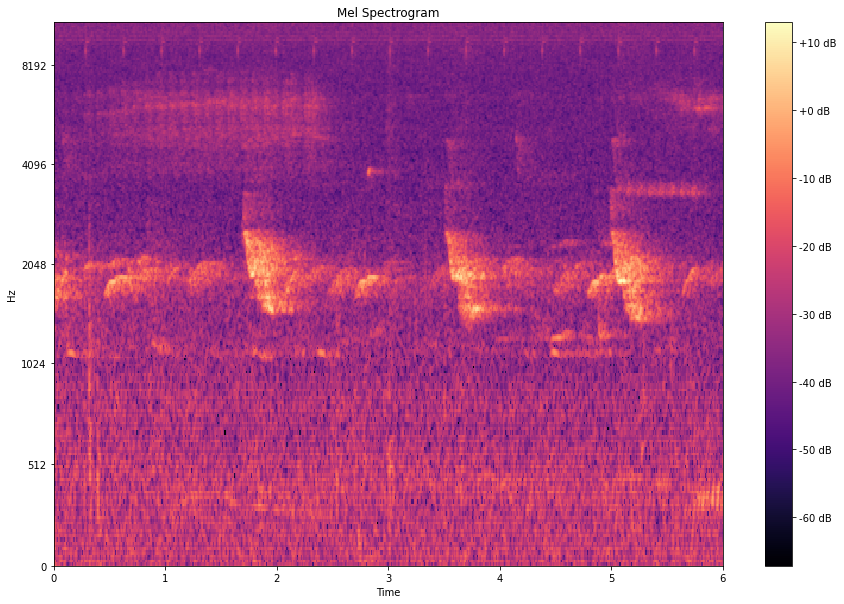

In [4]:
def check_correct() -> None:
    
    # make file
    recording_id = 'c12e0a62b'#'00204008d'
    idx = 915
    path_save = './'
    gen_mel_img(df, recording_id, idx, path_save, f_min, f_max, test=False)    
    img = np.load(os.path.join(path_save, recording_id + '.9'+ '.915') + '.npy')
    
    plt.figure(figsize = (15, 10))
    librosa.display.specshow(img, sr = SAMPLERATE, y_axis='mel', x_axis='time');
    plt.title('Mel Spectrogram');
    plt.colorbar(format='%+2.0f dB');
    print(img.shape)    
    
check_correct()

In [5]:
!rm ./*.*

In [6]:
# ! mkdir /kaggle/working/train
! mkdir /kaggle/working/test

In [7]:
path_save = './train'    
Parallel(n_jobs = -1)(delayed(gen_mel_img)(df,
                                            name_id,
                                            idx,
                                            path_save,
                                            f_min,
                                            f_max,
                                            test = None
                                            )
                                            for idx, name_id in tqdm(enumerate(tp.recording_id.values))
                                            )# time 6.07, 1.3Gb

In [8]:
def save_to_zip(out_path):
    # ZIP & rm -rf (remove) folder

    if 'train' in out_path:
        !zip -r train_img.zip train
        !rm -rf train  

In [9]:
save_to_zip(path_save)

In [ ]:
path_save = './test'
test_path = glob.glob('../input/rfcx-species-audio-detection/test/*.flac')
Parallel(n_jobs = -1)(delayed(gen_mel_img)(df,
                                            name_id,
                                            idx,
                                            path_save,
                                            f_min,
                                            f_max,
                                            True
                                            )
                                            for idx, name_id in tqdm(enumerate(test_path[1000:]))
                                            ) # time 4.10, 5.7Gb

In [11]:
def save_to_zip(out_path):
    # ZIP & rm -rf (remove) folder

    if 'test' in out_path:
        !zip -r test_img.zip test
        !rm -rf test   

In [ ]:
save_to_zip(path_save)